In [1]:
import numpy as np
import pandas as pd
import warnings
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from re import sub
import pickle

warnings.filterwarnings('ignore')

In [2]:
# model packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
# from scipy.optimize import minimize

In [3]:
df_clean = pd.read_csv('data/modelData.csv')
df_clean['zipcode'] = df_clean['zipcode'].astype('category')

In [4]:
# one-hot for categorical column (>= 3 categories)
to_categorical = ['zipcode', 'property_type', 'room_type', 'bed_type', 'peak_month']


df_clean = pd.concat([df_clean, pd.get_dummies(df_clean[to_categorical],
                                              prefix=['zipcode_', 'propertyType_', 'roomType_', 'bedType_', 'peakMonth_'], 
                                              drop_first=True)], axis = 1)

In [5]:
# not_features = ['listing_id','date','dayWeek','month','host_since','city', 'year', 'day'] + to_categorical
not_features = to_categorical

In [6]:
df_final = df_clean.drop(not_features, axis = 1)

In [7]:
df_final.shape

(1636278, 113)

The features we have include:
- price_daily
- pull distance (how far the date is from the time pulling the data)
- host info: host_length (when doing optimization for new hosts, set 0)
- time info: weekend, peak_month
- property info: zipcode, property type, room type, bed type, acommodates, bathrooms, bedrooms, beds, guests_included, extra_people
- related fees info: security_deposit, cleaning_fee

## Predictive Model (The probability of getting rent)

In this predictive model, we are finding the mapping for (price, other variables) to (the probability of getting rent)

In [8]:
np.random.seed(2019)
negative_index = df_final[(df_final.pull_distance == 0) & (df_final.unavailable == 0)].index
upsample_index = np.random.choice(negative_index, np.sum(df_final[df_final['pull_distance'] == 0]['unavailable'])-len(negative_index))

df_final = df_final.append(df_final.iloc[upsample_index])

In [9]:
X = df_final.drop(['unavailable'], axis = 1)
Y = df_final['unavailable']

The probability of Being Rent is 0.62


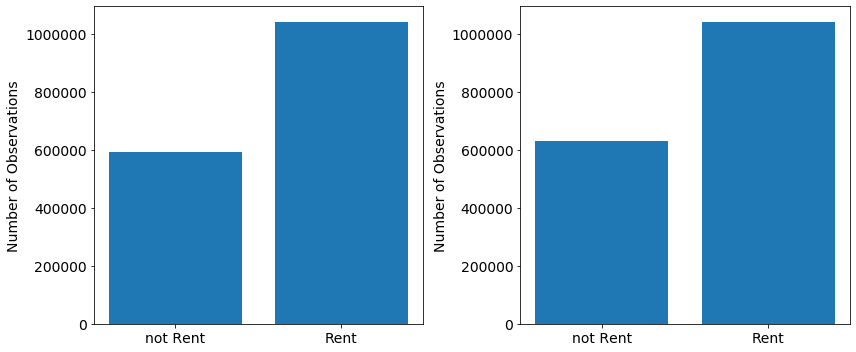

In [10]:
# Data Balance check
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].bar([1,2], [len(Y)-np.sum(Y)-len(upsample_index), np.sum(Y)])
ax[1].bar([1,2], [len(Y)-np.sum(Y), np.sum(Y)])
ax[0].set_xticks([1,2])
ax[0].set_xticklabels(['not Rent', 'Rent'])
ax[0].tick_params(labelsize=14)
ax[0].set_ylabel('Number of Observations',fontsize=14)
ax[1].set_xticks([1,2])
ax[1].set_xticklabels(['not Rent', 'Rent'])
ax[1].set_ylabel('Number of Observations',fontsize=14)
ax[1].tick_params(labelsize=14)
plt.tight_layout()
print('The probability of Being Rent is {0:4.2f}'.format(np.sum(Y)/len(Y)))

0. Train-Test Split

In [11]:
X_TRAIN, X_test, Y_TRAIN,  y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2019)
# X_train, X_val, y_train,  y_val = train_test_split(X_TRAIN, Y_TRAIN, test_size = 0.2, random_state = 2019)

print('# Training Images: {}'.format(len(X_TRAIN)))
# print('# Validation Images: {}'.format(len(X_val)))
print('# Test Images: {}'.format(len(X_test)))

# Training Images: 1338276
# Test Images: 334569


1. Logistic Regression (with built-in cross validation for selecting Cs values and l1_ratios)

In [22]:
k = KFold(5, random_state = 2019, shuffle=True)
clf = LogisticRegressionCV(cv = k, random_state = 2019).fit(X_TRAIN, Y_TRAIN)

In [23]:
print('The accuracy for Logistic Regression on Train set is {0:6.4f}'.format(clf.score(X_TRAIN, Y_TRAIN)))
print('The accuracy for Logistic Regression on Test set is {0:6.4f}'.format(clf.score(X_test, y_test)))

The accuracy for Logistic Regression on Train set is 0.6947
The accuracy for Logistic Regression on Test set is 0.6944


2. KNN (with cross validation for selecting n_neighbors)

In [27]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(100, 0, -10)}
knn_gscv = GridSearchCV(knn, param_grid, cv = k)
knn_gscv.fit(X_TRAIN, Y_TRAIN)

GridSearchCV(cv=KFold(n_splits=5, random_state=2019, shuffle=True),
             error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([100,  90,  80,  70,  60,  50,  40,  30,  20,  10])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [30]:
print('The accuracy for KNN on Train set is {0:6.4f}'.format(knn_gscv.score(X_TRAIN, Y_TRAIN)))
print('The accuracy for KNN on Test set is {0:6.4f}'.format(knn_gscv.score(X_test, y_test)))

The accuracy for KNN on Train set is 0.9052
The accuracy for KNN on Test set is 0.8804


In [34]:
knn_gscv.best_params_ #cv_results_

{'n_neighbors': 10}

3. Decision Trees

In [38]:
tree = DecisionTreeClassifier(min_samples_split=20).fit(X_TRAIN, Y_TRAIN)

In [39]:
print('The accuracy for Decision Tree on Train set is {0:6.4f}'.format(tree.score(X_TRAIN, Y_TRAIN)))
print('The accuracy for Decision Tree on Test set is {0:6.4f}'.format(tree.score(X_test, y_test)))

The accuracy for Decision Tree on Train set is 0.9332
The accuracy for Decision Tree on Test set is 0.8826


4. Random Forest

In [46]:
rf = RandomForestClassifier(n_estimators = 50, random_state = 42,
                            min_samples_leaf=10,min_samples_split=30,max_features=0.6).fit(X_TRAIN, Y_TRAIN)

In [47]:
print('The accuracy for random forest on Train set is {0:6.4f}'.format(rf.score(X_TRAIN, Y_TRAIN)))
print('The accuracy for random forest on Test set is {0:6.4f}'.format(rf.score(X_test, y_test)))

The accuracy for random forest on Train set is 0.9171
The accuracy for random forest on Test set is 0.8904


5. AdaBoost

In [49]:
ada = AdaBoostClassifier(n_estimators=50, learning_rate=1.0,
                         random_state = 42).fit(X_TRAIN, Y_TRAIN)

In [50]:
print('The accuracy for AdaBoost Classifier on Train set is {0:6.4f}'.format(ada.score(X_TRAIN, Y_TRAIN)))
print('The accuracy for AdaBoost Classifier on Test set is {0:6.4f}'.format(ada.score(X_test, y_test)))

The accuracy for AdaBoost Classifier on Train set is 0.7064
The accuracy for AdaBoost Classifier on Test set is 0.7070


6. Gradient Boosting

In [55]:
grad = GradientBoostingClassifier(learning_rate=0.1,n_estimators=100,subsample=0.8,
                                  min_samples_leaf=10,min_samples_split=30,
                                  random_state = 42).fit(X_TRAIN, Y_TRAIN)

In [56]:
print('The accuracy for GradientBoosting Classifier on Train set is {0:6.4f}'.format(grad.score(X_TRAIN, Y_TRAIN)))
print('The accuracy for GradientBoosting Classifier on Test set is {0:6.4f}'.format(grad.score(X_test, y_test)))

The accuracy for GradientBoosting Classifier on Train set is 0.7332
The accuracy for GradientBoosting Classifier on Test set is 0.7344


7. Model selection

Random Forest has the highest Test set accuracy and the least overfitting.

In [18]:
pickle.dump(rf, open('rf.sav', 'wb'))
# rf = pickle.load(open('rf.sav', 'rb'))

8. Feature Importance

In [21]:
rf_featureimp = pd.DataFrame({'Feature':X.columns,'Importance':rf.feature_importances_})
rf_featureimp = rf_featureimp.sort_values(by='Importance',ascending=False).head(20)

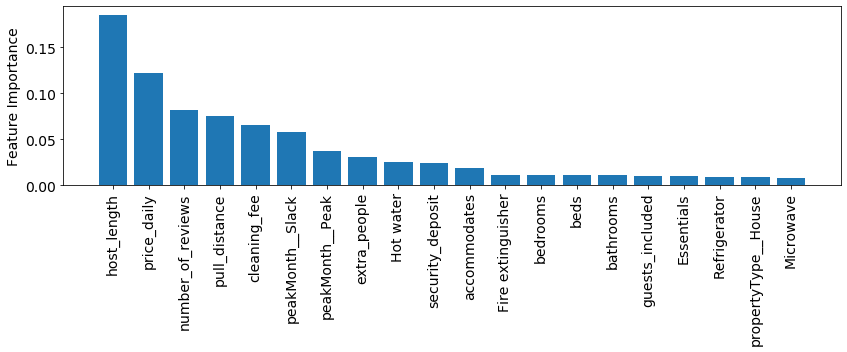

In [22]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
ax.bar(rf_featureimp.Feature, rf_featureimp.Importance)
ax.set_xticklabels(rf_featureimp.Feature,rotation=90)
ax.set_ylabel('Feature Importance',fontsize=14)
ax.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('feature_imp2.png')